In [1]:
import pandas as pd

# 1.1 Load Data 
titanic = pd.read_csv("datasets/titanic/train.csv")
prod_test = pd.read_csv("datasets/titanic/test.csv")

In [2]:
# 1.2 Split to train and test
from sklearn.model_selection import train_test_split

seed = 42
titanic_train, titanic_test = train_test_split(titanic, random_state=seed, test_size=0.2)

In [3]:
# separating label and features
X_train = titanic_train.drop("Survived", axis=1)
y_train = titanic_train["Survived"]

In [4]:
# Label distribution
import seaborn
seaborn.countplot(y_train)
y_train.value_counts()

0    444
1    268
Name: Survived, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E5969B0>,
      dtype=object)

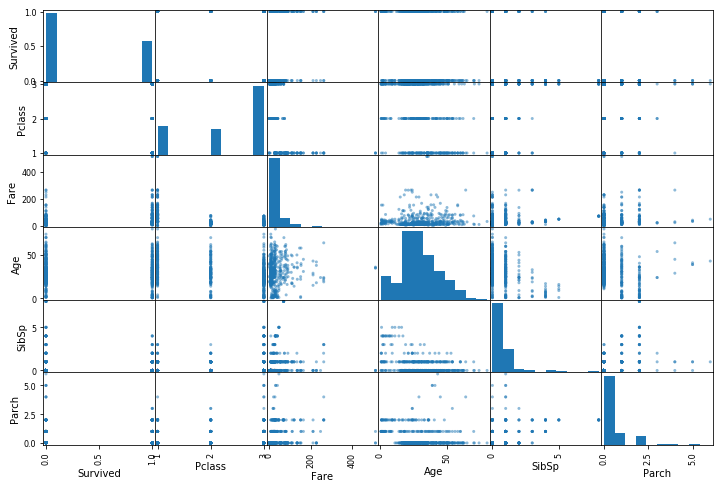

In [5]:
## Investigating correlations between variables (doing this earlier before separating label and features)
from pandas.plotting import scatter_matrix

attributes = ["Sex", "Survived", "Pclass", "Fare", "Age", "SibSp", "Parch"]
scatter_matrix(titanic_train[attributes], figsize=(12,8)) # => No strong correlation remarkable !

In [6]:
X_train.info() # Age and cabin features are missing for some passengers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 11 columns):
PassengerId    712 non-null int64
Pclass         712 non-null int64
Name           712 non-null object
Sex            712 non-null object
Age            572 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Ticket         712 non-null object
Fare           712 non-null float64
Cabin          159 non-null object
Embarked       710 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 86.8+ KB


In [7]:
X_train.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,572.000000,712.000000,712.000000,712.000000
mean,448.234551,2.330056,29.498846,0.553371,0.379213,32.586276
std,256.731423,0.824584,14.500059,1.176404,0.791669,51.969529
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,224.750000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,453.500000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,673.500000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
# passengerId, Name don't give us any information + cabin lot of missing values => we simply don't use these features 
X_train = X_train.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis=1)

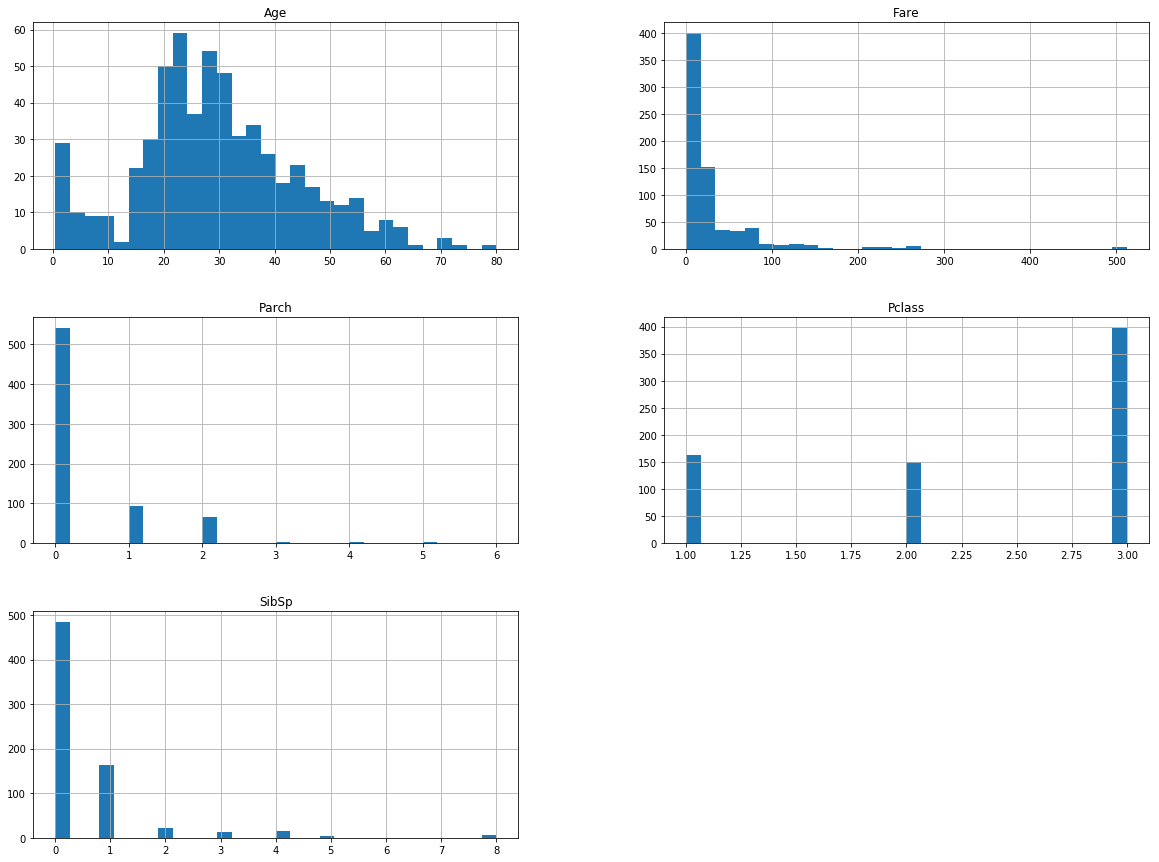

In [9]:
## 2 Data Exploration
## 2.1 Distribution of each variable
import matplotlib.pyplot as plt
X_train.hist(bins=30, figsize=(20,15))
plt.show()

In [10]:
corr_matrix = titanic_train.corr()
corr_matrix["Survived"].sort_values(ascending=False)  # Fare has 0.24 correlation with the label, #Pclass has -0.32 correlation with the label

Survived       1.000000
Fare           0.246641
Parch          0.078311
PassengerId    0.019979
SibSp         -0.047602
Age           -0.059695
Pclass        -0.321750
Name: Survived, dtype: float64

In [11]:
corr_matrix["Pclass"].sort_values(ascending=False) # The previous 2 features (Fare and Pclass) have a relatively strong correlation between each other (-0.54) 

Pclass         1.000000
SibSp          0.086933
Parch          0.012679
PassengerId   -0.046175
Survived      -0.321750
Age           -0.355950
Fare          -0.546794
Name: Pclass, dtype: float64

In [12]:
## 2.4 Experimenting with Attribute Combinations

titanic_train["PdivS"] = titanic_train["Parch"] / titanic_train["SibSp"]
titanic_train["SmulP"] = titanic_train["Parch"] * titanic_train["SibSp"]
titanic_train["SaddP"] = titanic_train["Parch"] + titanic_train["SibSp"]
titanic_train["SminusP"] = titanic_train["SibSp"] - titanic_train["Parch"]
corr_matrix = titanic_train.corr()
corr_matrix["Survived"].sort_values(ascending=False)

# Adding some of these combinations is a little bit more correlated with the label than the variables taken independently
# SminusP -0.10, SmulP 0.08

c:\users\ayoub\desktop\ml\env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\ayoub\desktop\ml\env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\ayoub\desktop\ml\env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Survived       1.000000
Fare           0.246641
Parch          0.078311
PassengerId    0.019979
PdivS          0.006422
SaddP          0.003565
SibSp         -0.047602
Age           -0.059695
SmulP         -0.081532
SminusP       -0.108146
Pclass        -0.321750
Name: Survived, dtype: float64

In [13]:
# Adding the important combinations
X_train["SmulP"] = X_train["SibSp"] * X_train["Parch"]
X_train["SminusP"] = X_train["SibSp"] - X_train["Parch"]

In [14]:
## 3.1 Dealing with Missing values (Age)
median = X_train["Age"].median() # storing the median to use it in the test set
median_fare = X_train["Fare"].median()
X_train["Age"].fillna(median, inplace=True)

## Dealing with Missing values in Embarked
X_train["Embarked"].fillna('S', inplace=True)

In [15]:
## 3.2 Transformation of Categorical Textual attributes (Embarked)
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
X_train_embarked = encoder.fit_transform(X_train["Embarked"].values.reshape(-1,1))

In [16]:
## Transform textual binary categorical to 0 and 1
X_train["Sex"] = (X_train["Sex"]=='male')

In [17]:
num_attributes = ["Age", "SibSp", "Parch", "SmulP", "SminusP", "Fare"]
cat_attributes = ["Pclass", "Sex"]

In [18]:
## 3.3 Numerical Feature Scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

X_train_num = X_train[num_attributes]
X_train_num_tr = num_pipeline.fit_transform(X_train_num)

c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [19]:
## Merging X_train_num_tr, X_train[cat_attributes], X_train_embarked
import numpy as np
X_train_embarked.toarray()
X_train_final = np.concatenate((X_train_num_tr, X_train_embarked.toarray(), X_train[cat_attributes].values), axis = 1)

In [20]:
X_train_final.shape

(712, 11)

In [21]:
### 4.1 Training a model
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42)
cross_val_score(sgd_clf, X_train_final, y_train, cv=3, scoring="accuracy")

c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they defau

array([0.72268908, 0.78902954, 0.75105485])

In [22]:
### 4.1 Training a second model
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
cross_val_score(forest_clf, X_train_final, y_train, cv=3, scoring="accuracy")
# => More promising than the first one

c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0.76470588, 0.79324895, 0.79746835])

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
cross_val_score(knn_clf, X_train_final, y_train, cv=3, scoring="accuracy")

array([0.73529412, 0.7721519 , 0.79324895])

In [24]:
from sklearn.svm import SVC

svc_clf = SVC(random_state=42)
cross_val_score(svc_clf, X_train_final, y_train, cv=3, scoring="accuracy")
# => more promising so far

c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0.81092437, 0.82278481, 0.81434599])

In [25]:
from sklearn.naive_bayes import GaussianNB

gaussian_clf = GaussianNB()
cross_val_score(gaussian_clf, X_train_final, y_train, cv=3, scoring="accuracy")

array([0.75630252, 0.70886076, 0.70464135])

In [26]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
cross_val_score(tree_clf, X_train_final, y_train, cv=3, scoring="accuracy")

array([0.74789916, 0.75527426, 0.76371308])

In [27]:
### 4.2 Tuning SVC
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [2, 3, 4, 5], 'gamma': ['auto', 'scale']}
]

svc_clf = SVC()
grid_search = GridSearchCV(svc_clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_final, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [2, 3, 4, 5], 'gamma': ['auto', 'scale']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [28]:
cvres = grid_search.cv_results_
for accuracy, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(accuracy, params)

0.8160112359550562 {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
0.7949438202247191 {'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
0.8033707865168539 {'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
0.723314606741573 {'degree': 2, 'gamma': 'auto', 'kernel': 'sigmoid'}
0.8174157303370787 {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
0.7949438202247191 {'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
0.8019662921348315 {'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
0.7443820224719101 {'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.8160112359550562 {'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
0.7949438202247191 {'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}
0.7935393258426966 {'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
0.723314606741573 {'degree': 3, 'gamma': 'auto', 'kernel': 'sigmoid'}
0.8174157303370787 {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
0.7949438202247191 {'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
0.7808988764044944 {'degree': 3

In [29]:
grid_search.best_params_

{'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

In [30]:
### 4.2 Tuning RandomForest

param_grid = [
    {'n_estimators': [10, 100, 200], 'criterion': ["gini", "entropy"], 'min_samples_split': [20, 30, 40], "max_features": ['auto', 'log2']}
]

forest_clf = RandomForestClassifier()
grid_search = GridSearchCV(forest_clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_final, y_train)

cvres = grid_search.cv_results_
for accuracy, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(accuracy, params)

0.8160112359550562 {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 20, 'n_estimators': 10}
0.824438202247191 {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 20, 'n_estimators': 100}
0.8188202247191011 {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 20, 'n_estimators': 200}
0.800561797752809 {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 30, 'n_estimators': 10}
0.8117977528089888 {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 30, 'n_estimators': 100}
0.8117977528089888 {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 30, 'n_estimators': 200}
0.8075842696629213 {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 40, 'n_estimators': 10}
0.8117977528089888 {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 40, 'n_estimators': 100}
0.8188202247191011 {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 40, 'n_estimators': 200}
0.8174

In [31]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_split': 30,
 'n_estimators': 10}

In [32]:
forest_clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features='auto', min_samples_split=20)
forest_clf.fit(X_train_final, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
svc_clf = SVC(random_state=42)
cross_val_score(svc_clf, X_train_final, y_train, cv=3, scoring="accuracy")
svc_clf.fit(X_train_final, y_train)

c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\svm\base

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [34]:
## 4.1 Model Evaluation
X_test = titanic_test.drop("Survived", axis=1)
y_test = titanic_test["Survived"]

X_test = X_test.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis=1)

X_test["SmulP"] = X_test["SibSp"] * X_test["Parch"]
X_test["SminusP"] = X_test["SibSp"] - X_test["Parch"]

X_test["Age"].fillna(median, inplace=True)
X_test["Embarked"].fillna('S', inplace=True)

encoder = OneHotEncoder()
X_test_embarked = encoder.fit_transform(X_test["Embarked"].values.reshape(-1,1))

X_test["Sex"] = (X_test["Sex"]=='male')

X_test_num = X_test[num_attributes]
X_test_num_tr = num_pipeline.fit_transform(X_test_num)

X_test_embarked.toarray()
X_test_final = np.concatenate((X_test_num_tr, X_test_embarked.toarray(), X_test[cat_attributes].values), axis = 1)
X_test_final.shape

c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(179, 11)

In [35]:
from sklearn.metrics import confusion_matrix
# predicted_values = svc_clf.predict(X_test_final)
predicted_values = forest_clf.predict(X_test_final)
conf_mtx = confusion_matrix(predicted_values, y_test)
accuracy = (conf_mtx[0][0]+conf_mtx[1][1])/len(predicted_values)
accuracy

0.8044692737430168

In [36]:
prod_test = prod_test.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis=1)

prod_test["SmulP"] = prod_test["SibSp"] * prod_test["Parch"]
prod_test["SminusP"] = prod_test["SibSp"] - prod_test["Parch"]

prod_test["Age"].fillna(median, inplace=True)
prod_test["Fare"].fillna(median_fare, inplace=True)
prod_test["Embarked"].fillna('S', inplace=True)

encoder = OneHotEncoder()
prod_test_embarked = encoder.fit_transform(prod_test["Embarked"].values.reshape(-1,1))

prod_test["Sex"] = (prod_test["Sex"]=='male')

prod_test_num = prod_test[num_attributes]
prod_test_num_tr = num_pipeline.fit_transform(prod_test_num)

prod_test_embarked.toarray()
prod_test_final = np.concatenate((prod_test_num_tr, prod_test_embarked.toarray(), prod_test[cat_attributes].values), axis = 1)
prod_test_final.shape

c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\ayoub\desktop\ml\env\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(418, 11)

In [37]:
# predicted_labels = svc_clf.predict(prod_test_final)
predicted_labels = forest_clf.predict(prod_test_final)

In [38]:
results = pd.Series(predicted_labels, name="Survived")

submission = pd.concat([pd.Series(range(892,1310), name = "PassengerId"), results], axis = 1)

submission["Survived"] = submission["Survived"].astype('str')

submission.to_csv("~/Desktop/titanic_submit.csv", index=False)

In [39]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
